In [8]:
#
# Copyright (C)  2020  University of Pisa
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
#
import itertools
import networkx as nx
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def convert(data):
    G = to_networkx(data)
    G.graph['label'] = data.y.item()
    return nx.to_undirected(G)


def dataset_to_graphs(dataset):
    graphs = []
    for data in dataset:
        graphs.append(convert(data))
    return graphs
    

def check(graphs):
    num_iso_pairs = 0
    num_inconsistent_labels = 0
    num_graphs = len(graphs)
    combinations = itertools.combinations(range(num_graphs), 2)
    
    for (i1, i2) in combinations:
        G1, G2 = graphs[i1], graphs[i2]
        label1, label2 = G1.graph['label'], G2.graph['label']
        
        if nx.is_isomorphic(G1, G2):
            num_iso_pairs += 1
            if label1 != label2:
                num_inconsistent_labels += 1
    
    print(f"number of isomorphic pairs: {num_iso_pairs}") 
    print(f"number of isomorphic pairs with inconsistent labels: {num_inconsistent_labels}")
    print(f"ratio of inconsistently labelled isomorphic pairs vs. isomorphic pairs: {num_inconsistent_labels / num_iso_pairs:.4f}")

In [4]:
dataset_name = "IMDB-BINARY"

print(f"############## Checking dataset {dataset_name} ##############")
dataset = TUDataset(f'tmp/{dataset_name}', dataset_name)
graphs = dataset_to_graphs(dataset)

# WARNING: this might take several minutes depending on your hardware
check(graphs)

############## Checking dataset IMDB-BINARY ##############


Extracting tmp/IMDB-BINARY/IMDB-BINARY/IMDB-BINARY.zip
Processing...
Done!


number of isomorphic pairs: 3356
number of isomorphic pairs with inconsistent labels: 1119
ratio of inconsistently labelled isomorphic pairs vs. isomorphic pairs: 0.3334


G1 label: 0 - G2 label: 1


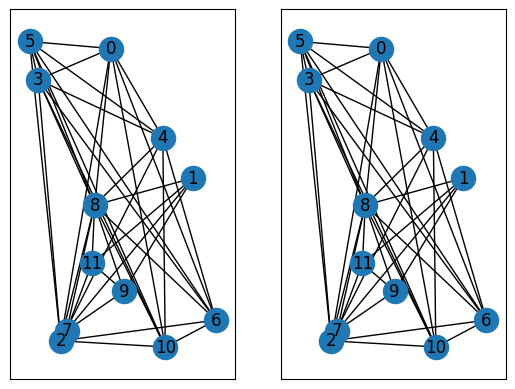

In [9]:
def bfs_seq(G, start_id):
    """ taken from https://github.com/JiaxuanYou/graph-generation/blob/master/data.py """
    dictionary = dict(nx.bfs_successors(G, start_id))
    start = [start_id]
    output = [start_id]
    while len(start) > 0:
        next = []
        while len(start) > 0:
            current = start.pop(0)
            neighbor = dictionary.get(current)
            if neighbor is not None:
                next = next + neighbor
        output = output + next
        start = next
    return output

# 10 and 710 have different labels, but are isomorphic
G1, G2 = graphs[10], graphs[710]

# reorder nodes
seq1, seq2 = bfs_seq(G1, 0), bfs_seq(G2, 0)
G2 = nx.relabel_nodes(G2, {n:m for n, m in zip(seq2, seq1)})
print(f"G1 label: {G1.graph['label']} - G2 label: {G2.graph['label']}")

fig, axs = plt.subplots(1, 2)
pos = nx.random_layout(G1, seed=42)
nx.draw_networkx(G1, pos=pos, ax=axs.flat[0])
nx.draw_networkx(G2, pos=pos, ax=axs.flat[1])